In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_bubble (4).png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_branch.png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_branch (2).png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_create (5).png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_active (5).png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_canvas.png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_assume(1).png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_avenue (3).png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_carbon (3).png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_bubble (2).png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_occupy (4).png
/kaggle/input/qr-dataset/Assignment Data/Second Print/input_image_belong (2).png
/kaggle/input/qr-dataset/Assignment D

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.getcwd()

'/kaggle/working'

In [4]:
dataset_path = "/kaggle/input/qr-dataset/Assignment Data"

In [5]:
first_print_path = os.path.join(dataset_path, "First Print")
second_print_path = os.path.join(dataset_path, "Second Print")

# dataset statisctics

In [6]:
num_first_prints = len(os.listdir(first_print_path))
num_second_prints = len(os.listdir(second_print_path))

In [7]:
print(f"Number of Original QR Codes (First Prints): {num_first_prints}")
print(f"Number of Counterfeit QR Codes (Second Prints): {num_second_prints}")

Number of Original QR Codes (First Prints): 100
Number of Counterfeit QR Codes (Second Prints): 100


# sample images

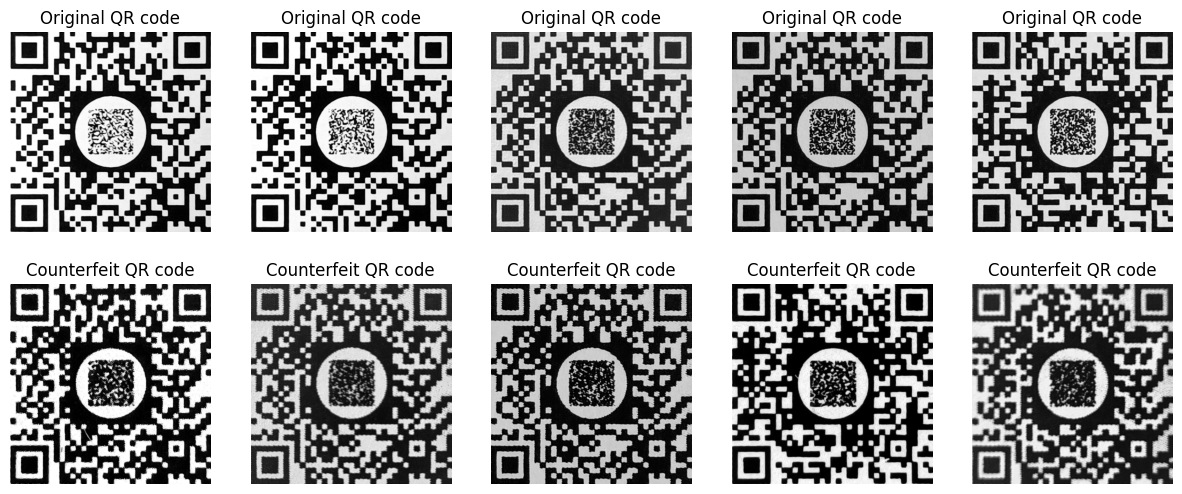

In [8]:
def display_sample_images():
    first_images = os.listdir(first_print_path)[:5]
    second_images = os.listdir(second_print_path)[:5]

    fig,axes = plt.subplots(2,5, figsize=(15,6))

    for i, img_name in enumerate(first_images):
        img = cv2.imread(os.path.join(first_print_path,img_name),cv2.IMREAD_GRAYSCALE)
        axes[0,i].imshow(img,cmap='gray')
        axes[0,i].set_title("Original QR code")
        axes[0,i].axis("off")

    for i, img_name in enumerate(second_images):
        img = cv2.imread(os.path.join(second_print_path,img_name),cv2.IMREAD_GRAYSCALE)
        axes[1,i].imshow(img,cmap='gray')
        axes[1,i].set_title("Counterfeit QR code")
        axes[1,i].axis("off")

    plt.show()

display_sample_images()

# exctracting basic features

In [9]:
def compute_image_stats(image_path):
    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    mean_intensity = np.mean(img)
    contrast = np.std(img)
    return mean_intensity, contrast


# stats for sample images
first_img_path = os.path.join(first_print_path,os.listdir(first_print_path)[0])
second_img_path = os.path.join(second_print_path, os.listdir(second_print_path)[0])

first_mean, first_contrast = compute_image_stats(first_img_path)
second_mean, second_contrast = compute_image_stats(second_img_path)

print(f"Original QR: Mean Brightness = {first_mean:.2f}, Contrast = {first_contrast:.2f}")
print(f"Counterfeit QR: Mean Brightness = {second_mean:.2f}, Contrast = {second_contrast:.2f}")

Original QR: Mean Brightness = 134.70, Contrast = 111.67
Counterfeit QR: Mean Brightness = 113.28, Contrast = 112.53


# feature extraction

In [10]:
from skimage.feature import graycomatrix, graycoprops
from scipy.fftpack import fft2, fftshift

In [11]:
def extract_features(image_path):
    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

    # global features

    mean_intensity = np.mean(img) # brightness
    contrast = np.std(img) # contrast
    edges = cv2.Canny(img,100,200) # edge detection
    edge_density = np.sum(edges)/ (img.shape[0]*img.shape[1]) # edge density

    # Local texture analysis

    laplacian_var = cv2.Laplacian(img,cv2.CV_64F).var() # Shapnes measure
    glcm = graycomatrix(img, distances=[1], angles=[0],levels=256,symmetric=True,normed=True)
    texture_contrast = graycoprops(glcm,'contrast')[0,0] # GLCM contrast

    # Frequency domain analysis (Fourier Transform)

    f_transform = fftshift(fft2(img))
    freq_variance = np.var(np.abs(f_transform)) # variation in frequency domain

    return [mean_intensity,contrast, edge_density , laplacian_var, texture_contrast , freq_variance]


first_sample = os.path.join(first_print_path,os.listdir(first_print_path)[0])
second_sample = os.path.join(second_print_path, os.listdir(second_print_path)[0])


first_features = extract_features(first_sample)
second_features = extract_features(second_sample)


print("feature comparison")
print(f"Original QR features : {first_features}")
print(f"Counterfeit QR featurs: {second_features}")
    

feature comparison
Original QR features : [134.6973383284899, 111.6686289094982, 12.352424634991772, 418.99259040346766, 339.54396786225084, 21672831254.83026]
Counterfeit QR featurs: [113.27676124567473, 112.52506715773616, 14.761764705882353, 360.45809442602456, 334.48330215478416, 18215260854.770515]


# model development

# ML model

## extracting all common features from all the first and second input images and storing them in a dataframe

In [12]:
X = [] # feature matrix
y = [] # Labels (0 = Original , 1 = Counterfeit)

### adding the features of the first input images

In [13]:
for img_name in os.listdir(first_print_path):
    img_path = os.path.join(first_print_path, img_name)
    features = extract_features(img_path) # calling the image extraction function
    X.append(features)
    y.append(0) # label is 0 because these are original images

### adding the features of the second input images

In [14]:
for img_name in os.listdir(second_print_path):
    img_path = os.path.join(second_print_path, img_name)
    features = extract_features(img_path) # calling the image extraction function
    X.append(features)
    y.append(1) # label is 0 because these are original images

### converting to dataframe

In [15]:
df = pd.DataFrame(X, columns = ['Mean_Brightness','Contrast','Edge_Density','Laplacian_Variance','GLCM_Contrast','Freq_Variance'])
df['Label'] = y

### how does the data look like

In [16]:
df.sample(6)

,Mean_Brightness,Contrast,Edge_Density,Laplacian_Variance,GLCM_Contrast,Freq_Variance,Label
61,110.793607,75.939208,10.601700,42.119049,80.095764,1.507692e+10,0
150,107.128502,116.075123,11.592838,458.362043,356.143568,1.747143e+10,1
13,122.943421,77.376047,10.305747,54.357786,88.100061,1.905148e+10,0
118,96.702541,83.126450,15.754119,250.769885,198.342423,9.455862e+09,1
26,125.056335,113.544174,11.010392,308.612707,274.080551,2.518068e+10,0
59,134.659128,109.546693,10.612329,292.292254,313.226890,2.832184e+10,0


### column info

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mean_Brightness     200 non-null    float64
 1   Contrast            200 non-null    float64
 2   Edge_Density        200 non-null    float64
 3   Laplacian_Variance  200 non-null    float64
 4   GLCM_Contrast       200 non-null    float64
 5   Freq_Variance       200 non-null    float64
 6   Label               200 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 11.1 KB


### since all are numerical we dont need any encoding

### how the data look mathematically

In [18]:
df.describe()

,Mean_Brightness,Contrast,Edge_Density,Laplacian_Variance,GLCM_Contrast,Freq_Variance,Label
count,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000
mean,113.388631,99.167876,12.975439,296.311660,257.752186,1.593307e+10,0.500000
std,13.527356,16.431191,1.718780,140.154875,98.669300,5.209629e+09,0.501255
min,87.411893,63.441438,10.305747,31.915233,62.042494,8.156978e+09,0.000000
25%,103.054324,85.777154,11.707709,231.528743,206.178862,1.085736e+10,0.000000
50%,109.680109,108.197299,12.593256,300.953264,274.865855,1.551443e+10,0.500000
75%,128.932317,113.014586,13.805494,369.723845,323.518295,1.999269e+10,1.000000
max,137.937328,120.262216,21.236491,666.646374,488.433715,2.832184e+10,1.000000


### here we can observe a huge difference between the values of columns to reduce it we will have to use a scaler like minmax scaler or standard scalar otherwise the model will not be able to caputre relations between the extracted features

### Splitting the dataset   into 80% training and 20% testing

In [19]:
from sklearn.model_selection import train_test_split 
xtrain,xtest,ytrain,ytest = train_test_split(df.drop('Label',axis=1),df['Label'], test_size=0.2, random_state = 42)

In [20]:
xtrain.shape, xtest.shape

((160, 6), (40, 6))

### scaling the features

In [21]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [22]:
xtrain_scaled = ss.fit_transform(xtrain)
xtest_scaled = ss.transform(xtest)

In [23]:
print("Dataset Prepared! Shape:", xtrain_scaled.shape, xtest_scaled.shape)

Dataset Prepared! Shape: (160, 6) (40, 6)


### model creation svm and random forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [25]:
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
svm_model = SVC(kernel='linear',C=1.0,random_state=42)

### training the model

In [26]:
rfc.fit(xtrain_scaled,ytrain)

RandomForestClassifier(random_state=42)

In [27]:
svm_model.fit(xtrain_scaled,ytrain)

SVC(kernel='linear', random_state=42)

### evaluating model performance

### making predictions

In [28]:
rf_preds = rfc.predict(xtest_scaled)
svm_preds = svm_model.predict(xtest_scaled)

In [29]:
from sklearn.metrics import classification_report as cr, accuracy_score , confusion_matrix

In [30]:
# Evaluate SVM
print("\n SVM Model Performance")
print("Accuracy:", accuracy_score(ytest, svm_preds))
print(cr(ytest, svm_preds))
print("Confusion Matrix:\n", confusion_matrix(ytest, svm_preds))


 SVM Model Performance
Accuracy: 0.975
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.95      0.97        19

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

Confusion Matrix:
 [[21  0]
 [ 1 18]]


In [31]:
# Evaluate Random Forest
print("\n Random Forest Model Performance")
print("Accuracy:", accuracy_score(ytest, rf_preds))
print(cr(ytest, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(ytest, rf_preds))


 Random Forest Model Performance
Accuracy: 0.975
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.95      0.97        19

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

Confusion Matrix:
 [[21  0]
 [ 1 18]]


# CNN Model

## image preprocessing

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
# defining the image and the batch size

IMG_SIZE = (128,128)
BATCH_SIZE = 32

In [34]:
# defining the image data generator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [35]:
# loaing the training dataset

train_generator = datagen.flow_from_directory(
    "/kaggle/input/qr-dataset/Assignment Data",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

Found 160 images belonging to 2 classes.


In [36]:
# loading validation dataset

val_generator = datagen.flow_from_directory(
    "/kaggle/input/qr-dataset/Assignment Data",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 40 images belonging to 2 classes.


## building the model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D,Flatten

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore best weights after stopping
)

In [39]:
cnn_model= Sequential([
    Conv2D(32, (3,3), activation='relu',input_shape=(128,128,3)),
    MaxPooling2D(pool_size=(2,2)),
    
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    

    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5), # prevents overfitting
    Dense(1,activation='sigmoid') # binary classification 
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# compile the model

In [40]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [41]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

### train the model

In [42]:
history = cnn_model.fit(
    train_generator,
    batch_size=32,
    epochs=10,
    validation_data = val_generator,
    callbacks=[early_stopping]
)
print("model training complete")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 865ms/step - accuracy: 0.4538 - loss: 5.6177 - val_accuracy: 0.5000 - val_loss: 1.3938
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 616ms/step - accuracy: 0.4764 - loss: 1.0860 - val_accuracy: 0.5000 - val_loss: 0.6861
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 616ms/step - accuracy: 0.5878 - loss: 0.7036 - val_accuracy: 0.5000 - val_loss: 0.6746
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 629ms/step - accuracy: 0.5608 - loss: 0.6761 - val_accuracy: 0.8000 - val_loss: 0.6561
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 666ms/step - accuracy: 0.6097 - loss: 0.6640 - val_accuracy: 0.7250 - val_loss: 0.6482
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 622ms/step - accuracy: 0.7641 - loss: 0.6365 - val_accuracy: 0.9250 - val_loss: 0.6058
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 624ms/step - accuracy: 0.8296 - loss: 0.5768 - val_accuracy: 0.8250 - val_loss: 0.5397
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 626ms/step - accuracy: 0.8056 - loss: 0.5097 - val_accuracy: 0.8500 - val_loss: 0.4745
Epo

Text(0.5, 1.0, 'Accuracy')

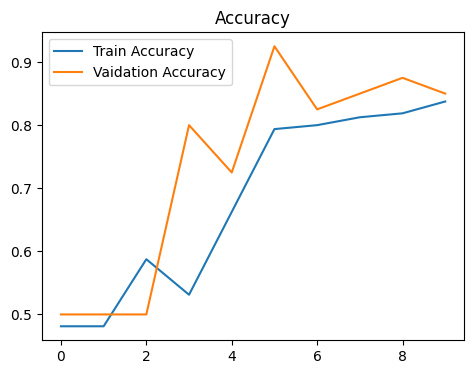

In [43]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Vaidation Accuracy')
plt.legend()
plt.title('Accuracy')

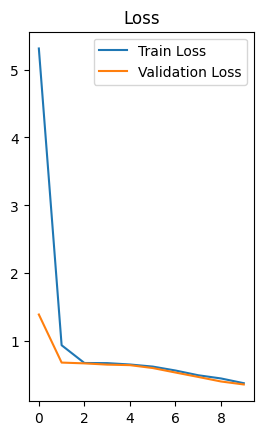

In [44]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [45]:
# Generate predictions on validation set
y_pred = (cnn_model.predict(val_generator) > 0.5).astype("int32")
y_true = val_generator.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


In [46]:
# Classification report
print("CNN Model Performance")
print(cr(y_true, y_pred))

CNN Model Performance
              precision    recall  f1-score   support

           0       0.64      0.45      0.53        20
           1       0.58      0.75      0.65        20

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.59        40
weighted avg       0.61      0.60      0.59        40



In [47]:
# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Confusion Matrix:
 [[ 9 11]
 [ 5 15]]
